In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [3]:
"""

#choppeddata_testset=pd.read_csv('choppeddata_10_04_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata2=pd.read_csv('choppeddata_10_06_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_3Xcopiedsuccess.csv')#.head()


choppeddata2=pd.read_csv('choppeddata_10_04_2021_3Xcopiedsuccess.csv')#.head()
choppeddata_testset=pd.read_csv('choppeddata_10_06_2021_randomselector_even.csv')#.head()

choppeddata3=pd.read_csv('choppeddata_10_13_2021_3Xcopiedsuccess.csv')#.head()

#choppeddata1=pd.read_csv('choppeddata_10_04_2021_randomselector_even.csv')#.head()
#choppeddata2=pd.read_csv('choppeddata_10_06_2021_randomselector_even.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_randomselector_even.csv')#.head()


#print(choppeddata1.shape)
print(choppeddata2.shape)
print(choppeddata3.shape)
#frames = [choppeddata1, choppeddata2,choppeddata3]
frames = [choppeddata2,choppeddata3]
choppeddata = pd.concat(frames)
"""

choppeddata=pd.read_csv('choppeddata_10_21_2021_3Xcopiedsuccess_fromtrain.csv')


print("contatenated data size:")
print(choppeddata.shape)




contatenated data size:
(12348, 10)


In [4]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels






(12348, 10)
total runs: 2058


In [5]:
#make test set with data outside of training set, because of duplication of successful runs. 
"""

print(choppeddata_testset.shape)
runqty_testset=int(choppeddata_testset.shape[0]/6)
print("total runs:",runqty_testset)

#put chopped data in np.arrays
State_testset=np.zeros((runqty_testset,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels_testset=np.zeros((runqty_testset,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata_testset.shape[0],6):
            State_testset[runcounter][0][:]=(choppeddata_testset[choppedheaders[:]].iloc[i]).tolist()
            State_testset[runcounter][1][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+1]).tolist()
            State_testset[runcounter][2][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+2]).tolist()
            State_testset[runcounter][3][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+3]).tolist()
            State_testset[runcounter][4][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+4]).tolist()
            Labels_testset[runcounter][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
"""

'\n\nprint(choppeddata_testset.shape)\nrunqty_testset=int(choppeddata_testset.shape[0]/6)\nprint("total runs:",runqty_testset)\n\n#put chopped data in np.arrays\nState_testset=np.zeros((runqty_testset,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long\nLabels_testset=np.zeros((runqty_testset,lookback)) #96 runs, each run is 11 timesteps long\nruncounter=0\n\nfor i in range(0,choppeddata_testset.shape[0],6):\n            State_testset[runcounter][0][:]=(choppeddata_testset[choppedheaders[:]].iloc[i]).tolist()\n            State_testset[runcounter][1][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+1]).tolist()\n            State_testset[runcounter][2][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+2]).tolist()\n            State_testset[runcounter][3][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+3]).tolist()\n            State_testset[runcounter][4][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+4]).tolist()\n            Lab

In [6]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size= float(.25),#.25 #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set X size", train_x.shape)
print("Train set Y size", train_y.shape)
#print(test_x[0])
#print(test_y[0])
print("Test set X size", test_x.shape)
print("Test set Y size", test_y.shape)

x.shape (2058, 5, 10)
Test set X size (1543, 5, 10)
Train set Y size (1543, 1)
Test set X size (515, 5, 10)
Test set Y size (515, 1)


In [7]:
#X= range(0,575,6)
#y= range(0,575,6)
"""

X_testset=State_testset
y_testset=Labels_testset[:,lookback-1]
print("x.shape",X.shape)

y_testset=y_testset.reshape(runqty_testset,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x_testset, test_x_testset, train_y_testset,test_y_testset = train_test_split(X_testset, y_testset, test_size=.999,#.25 #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set X size", train_x_testset.shape)
print("Train set Y size", train_y_testset.shape)
#print(test_x[0])
#print(test_y[0])
print("Test set X size", test_x_testset.shape)
print("Test set Y size", test_y_testset.shape)
"""

'\n\nX_testset=State_testset\ny_testset=Labels_testset[:,lookback-1]\nprint("x.shape",X.shape)\n\ny_testset=y_testset.reshape(runqty_testset,1)\n\nrandom_seed=int(time.time())\n#print(int(time.time()))\ntrain_x_testset, test_x_testset, train_y_testset,test_y_testset = train_test_split(X_testset, y_testset, test_size=.999,#.25 #0.33, \n                                                   random_state=random_seed)\n#print("Train")\n#print(train_x[0])\n#print(train_y[0])\nprint("Test set X size", train_x_testset.shape)\nprint("Train set Y size", train_y_testset.shape)\n#print(test_x[0])\n#print(test_y[0])\nprint("Test set X size", test_x_testset.shape)\nprint("Test set Y size", test_y_testset.shape)\n'

We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [8]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist

def train_existing_model(model,train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    """
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    """    
        
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist


def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    #start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE                               

def evaluatefull_maxdiff(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)


def evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=0.5, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    gru_outputs, targets= evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)
    #print("Vs Training Set")
    #print(gru_outputs[0][4])
    traincounter_falsenegative=0
    traincounter_falsepositive=0
    
    traincounter_truenegative=0
    traincounter_truepositive=0
    for i in range(int(trainy.size)):
        
        if trainy[i]==1  and gru_outputs[0][i]>= cutoff:
            traincounter_truepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truepositive" )
        elif trainy[i]==1  and gru_outputs[0][i]< cutoff:
            traincounter_falsenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif trainy[i]==0 and gru_outputs[0][i]<= cutoff :
            traincounter_truenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif trainy[i]==0 and gru_outputs[0][i]> cutoff:
            traincounter_falsepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsepositive" )     
                
           
    #print("TRAINING SET: Fails for button not pressed:",  train_failzerocounter,"Fails for button pressed:", train_failonecounter )        
    test_successcounter=0
    test_failzerocounter=0
    test_failonecounter=0
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    gru_outputs, targets = evaluate2(gru_model, test_x, test_y)
    #print("Vs Test Set")
    #print(gru_outputs[0][4])
    #print("test size: ",testy.size)


    testcounter_falsenegative=0
    testcounter_falsepositive=0
    
    testcounter_truenegative=0
    testcounter_truepositive=0
    for i in range(int(testy.size)):
        
        if testy[i]==1  and gru_outputs[0][i]>= cutoff:
            testcounter_truepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truepositive" )
        elif testy[i]==1  and gru_outputs[0][i]< cutoff:
            testcounter_falsenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif testy[i]==0 and gru_outputs[0][i]<= cutoff :
            testcounter_truenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif testy[i]==0 and gru_outputs[0][i]> cutoff:
            testcounter_falsepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsepositive" )   
    
    print(" vs training data=" ,traincounter_truepositive+traincounter_truenegative,"/",trainy.size, " vs test data=" ,
          testcounter_truepositive+testcounter_truenegative,"/",testy.size,round((100*(testcounter_truepositive+testcounter_truenegative)/testy.size),2),"%", "at cutoff",cutoff )
    
    
    print("TEST SET: True Positives",testcounter_truepositive,"True Negatives", testcounter_truenegative," False Positives",testcounter_falsepositive,"False Negatives", testcounter_falsenegative)
    print("")
    return ( traincounter_truepositive+traincounter_truenegative, testcounter_truepositive+testcounter_truenegative)


x.shape (2058, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/400 Done, Total Loss: 0.039902810441465895   Time Elapsed: 0.19190599999999947 seconds
Epoch 80/400 Done, Total Loss: 0.028035759995570213   Time Elapsed: 0.19453999999999994 seconds
Epoch 120/400 Done, Total Loss: 0.022987537680213183   Time Elapsed: 0.19879900000000106 seconds
Epoch 160/400 Done, Total Loss: 0.017283253432954854   Time Elapsed: 0.19645699999999522 seconds
Epoch 200/400 Done, Total Loss: 0.016488102211345296   Time Elapsed: 0.19596899999999806 seconds
Epoch 240/400 Done, Total Loss: 0.013125308919067416   Time Elapsed: 0.1947499999999991 seconds
Epoch 280/400 Done, Total Loss: 0.017159357924659464   Time Elapsed: 0.20213800000000504 seconds
Epoch 320/400 Done, Total Loss: 0.010417922224102464   Time Elapsed: 0.1905000000000001 seconds
Epoch 360/400 Done, Total Loss: 0.010415532464927916   Time Elapsed: 0.211190000000002 seconds
Epoch 400/400 Done, Total Loss: 0.007173606329160975   Time Elapsed: 0.20085799999999665 seconds
Total Training Time: 80.467392999999

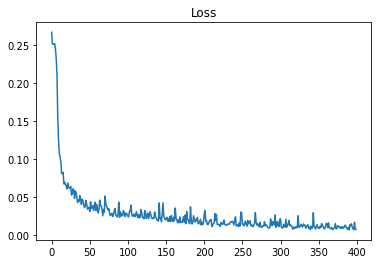

 vs training data= 1529 / 1543  vs test data= 503 / 515 97.67 % at cutoff 0.2
TEST SET: True Positives 239 True Negatives 264  False Positives 8 False Negatives 4

 vs training data= 1528 / 1543  vs test data= 502 / 515 97.48 % at cutoff 0.3
TEST SET: True Positives 237 True Negatives 265  False Positives 7 False Negatives 6

 vs training data= 1530 / 1543  vs test data= 503 / 515 97.67 % at cutoff 0.4
TEST SET: True Positives 237 True Negatives 266  False Positives 6 False Negatives 6

 vs training data= 1519 / 1543  vs test data= 495 / 515 96.12 % at cutoff 0.5
TEST SET: True Positives 228 True Negatives 267  False Positives 5 False Negatives 15

 vs training data= 1513 / 1543  vs test data= 493 / 515 95.73 % at cutoff 0.6
TEST SET: True Positives 225 True Negatives 268  False Positives 4 False Negatives 18

 vs training data= 1498 / 1543  vs test data= 489 / 515 94.95 % at cutoff 0.7
TEST SET: True Positives 221 True Negatives 268  False Positives 4 False Negatives 22

 vs training 

'\ngru_model2, losslist2 =train_existing_model(gru_model1,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")\n\ntrain2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.4)\ntrain2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.5)\ntrain3 ,test3=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.6)\ntrain4 ,test4=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.7)\n\ngru_model3, losslist3 =train_existing_model(gru_model2,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")\ntrain2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)\ntrain2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)\ntrain3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)\ntrain4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)\n\n\ngru_model4, losslis

In [9]:
lr = 0.0005
batch_size = 16
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size= float(.25),#.25 #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x), torch.from_numpy( test_y) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )




gru_model1, losslist1 =train(train_loader, lr , hidden_dim=128, EPOCHS=400 ,model_type="GRU") #1500  #had low total loss with batch size 32
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.2)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.5)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.6)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.7)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x, train_y, test_x, test_y,cutoff=.8)




"""
gru_model2, losslist2 =train_existing_model(gru_model1,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model3, losslist3 =train_existing_model(gru_model2,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)


gru_model4, losslist4 =train_existing_model(gru_model3,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model5, losslist5 =train_existing_model(gru_model4,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model6, losslist6 =train_existing_model(gru_model5,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model7, losslist7 =train_existing_model(gru_model6,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model8, losslist8 =train_existing_model(gru_model7,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.7)

fulllosslist=losslist1+losslist2+losslist3+losslist4+losslist5+losslist6+losslist7+losslist8
plt.plot(fulllosslist)
plt.title("Loss")
plt.show()
"""

In [13]:
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


 vs training data= 11111 / 11393  vs test data= 1525 / 1739 87.69 % at cutoff 0.1
TEST SET: True Positives 815 True Negatives 710  False Positives 160 False Negatives 54

 vs training data= 11318 / 11393  vs test data= 1586 / 1739 91.2 % at cutoff 0.2
TEST SET: True Positives 801 True Negatives 785  False Positives 85 False Negatives 68

 vs training data= 11358 / 11393  vs test data= 1608 / 1739 92.47 % at cutoff 0.3
TEST SET: True Positives 786 True Negatives 822  False Positives 48 False Negatives 83

 vs training data= 11378 / 11393  vs test data= 1605 / 1739 92.29 % at cutoff 0.4
TEST SET: True Positives 772 True Negatives 833  False Positives 37 False Negatives 97

 vs training data= 11388 / 11393  vs test data= 1597 / 1739 91.83 % at cutoff 0.5
TEST SET: True Positives 761 True Negatives 836  False Positives 34 False Negatives 108

 vs training data= 11388 / 11393  vs test data= 1596 / 1739 91.78 % at cutoff 0.6
TEST SET: True Positives 747 True Negatives 849  False Positives 21

In [10]:
def evaluate_episode(model, data, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [10]:
import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model1,"currentmodel_from_training_data_"+todaydate+".pt")


print("model saved")

10_21_2021
model saved


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test model on new data

In [11]:
gru_model3=torch.load('currentmodel_from_training_data_10_21_2021.pt',map_location=torch.device('cpu'))
gru_model3.eval()
print("loaded")

loaded


In [10]:
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)



NameError: name 'train_x_trainset' is not defined

In [18]:
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)

 vs training data= 12561 / 12569  vs test data= 4039 / 4042 99.93 % at cutoff 0.5
TEST SET: True Positives 2021 True Negatives 2018
TEST SET: False Positives 3 False Negatives 0



/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
randomindex=random.randint(0,225)
print("index=",randomindex)

exampledata=np.expand_dims(test_x[207, 0:5, 0:10], axis=0)

print(exampledata.shape)
prediction=evaluate_episode(gru_model3, exampledata)

print("prediction",float(prediction), "  actual",test_y[randomindex])

index= 44
(1, 5, 10)
prediction 0.2498023509979248   actual [0.]


## simlulate a buffer of 10 timesteps entering the classifier over a 1 episode, and classifying them. Filling empty data with zeroes or ones

In [12]:
outputlist=[]

randomindex=random.randint(0,225)
print("index=",randomindex)
exampledata=np.expand_dims(test_x[randomindex, 0:5, 0:10], axis=0)


#print(temparray.shape)
#temparray=np.expand_dims(temparray, axis=1)

#print(temparray.shape)
#print(temparray)

#temparray2=test_x[randomindex, 0:5, 0]
#temparray2=np.expand_dims(temparray2, axis=1)

for i in range(9):
    if i!=10:
        temparray=np.ones((5,1)) #test_x[randomindex, 0:5, 0]   #zeroes or "ones" here seems to work equally well. 
    
    for j in range(8-i):
        #temparray2=test_x[randomindex, 0:5, 0]
        #temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,np.ones((5,1)),axis=1)       #zeroes or "ones" here seems to work equally well. 
        #temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)   
    
    for j in range(i+1):

        temparray2=test_x[randomindex, 0:5, j]
        temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)

    
    #print(temparray)
    temparray=np.expand_dims(temparray, axis=0)
    outputpartial=evaluate_episode(gru_model3, temparray)
    
    
    outputlist.append(float(outputpartial))

print("final partial data")
print(temparray)   
print("")
print("full data")
print(exampledata)




#print("prediction from",x," timesteps",float(outputpartial),"actual",test_y[randomindex])
print("predictions:",outputlist)


#print("full data")
#print(exampledata)
print("")
#print("evaluating all 10 timesteps")

outputfull=evaluate_episode(gru_model3, exampledata)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",test_y[randomindex])


index= 188
final partial data
[[[1.         0.64779416 0.68590197 0.69517914 0.69903447 0.71459429
   0.71267351 0.71409191 0.71673093 0.72399386]
  [1.         0.52154944 0.52310862 0.53282553 0.52718083 0.53709991
   0.52978522 0.54277099 0.53688102 0.54443726]
  [1.         0.8726286  0.96482141 0.95083008 0.94447182 0.93691809
   0.95239155 0.9493714  0.95276295 0.95638539]
  [1.         0.50752062 0.50852903 0.49810241 0.50102952 0.4947311
   0.50046923 0.49000781 0.49422322 0.48543027]
  [1.         0.62007232 0.67079484 0.67376652 0.67304434 0.68618886
   0.68665851 0.69233506 0.69529406 0.70288601]]]

full data
[[[0.64779416 0.68590197 0.69517914 0.69903447 0.71459429 0.71267351
   0.71409191 0.71673093 0.72399386 0.7219988 ]
  [0.52154944 0.52310862 0.53282553 0.52718083 0.53709991 0.52978522
   0.54277099 0.53688102 0.54443726 0.53999553]
  [0.8726286  0.96482141 0.95083008 0.94447182 0.93691809 0.95239155
   0.9493714  0.95276295 0.95638539 0.94038139]
  [0.50752062 0.508529

## classifying progression of 10 actual forces and torques in a sucessful sequence longer than 10

In [15]:
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021_newrange.csv')#.head()
print(originaldata.shape)
headers=[]
lookback=30 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    headers.append("header"+label)
print(headers)

(7200, 30)
['header0', 'header1', 'header2', 'header3', 'header4', 'header5', 'header6', 'header7', 'header8', 'header9', 'header10', 'header11', 'header12', 'header13', 'header14', 'header15', 'header16', 'header17', 'header18', 'header19', 'header20', 'header21', 'header22', 'header23', 'header24', 'header25', 'header26', 'header27', 'header28', 'header29']


In [20]:
originaldata.iloc[4039:4044]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4039,-0.146118,-0.150491,-0.161489,-0.145119,-0.144571,-0.139811,-0.140801,-0.155982,-0.166506,-0.181792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4040,0.855510,0.854350,0.856338,0.850147,0.851591,0.854438,0.850040,0.839254,0.842253,0.845896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4041,0.186981,0.186524,0.187637,0.185199,0.188515,0.183551,0.182902,0.192211,0.219140,0.220496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4042,0.077426,0.079701,0.079563,0.080320,0.082692,0.082281,0.082844,0.103996,0.197891,0.189500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:

#print(originaldata[headers[0:30]].iloc[4039:4044])
#print(originaldata[headers[0:30]].iloc[4039:4044].to_numpy()
classifytest=originaldata[headers[19:29]].iloc[4038:4043].to_numpy()
labelstest=originaldata[headers[19:29]].iloc[4043].to_numpy()
print(classifytest)
classifytest=np.expand_dims(classifytest, axis=0)
print(classifytest.shape)
print(labelstest)

outputfull=evaluate_episode(gru_model3, classifytest)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",labelstest[9])

[[ 0.0731408   0.03829234  0.0469334   0.00194419 -0.01112242 -0.02011151
  -0.03633799 -0.03225345 -0.0420291   0.00937499]
 [-0.11749066 -0.23484093 -0.26258131 -0.25717197 -0.26656799 -0.25038209
  -0.26268438 -0.26090061 -0.26164099 -0.21694467]
 [ 0.86082529  0.77558722  0.85436662  0.84721256  0.85877484  0.84311893
   0.864341    0.85094293  0.84540413  0.70251442]
 [ 0.176776    0.27154119  0.30495647  0.30333233  0.30492832  0.29572228
   0.30752579  0.3070787   0.3079597   0.27827674]
 [ 0.07638625  0.02011034 -0.00378486 -0.02415284 -0.03190367 -0.04353291
  -0.05766036 -0.05307872 -0.05883769 -0.04239337]]
(1, 5, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

prediction from 10 timesteps 0.9415369629859924 actual 1.0


In [20]:

okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4296:4301].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4301].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : 0.10215329378843307 actual 0.0 OK
prediction from timestep 1 - 11  : 0.11250180751085281 actual 0.0 OK
prediction from timestep 2 - 12  : 0.014482356607913971 actual 0.0 OK
prediction from timestep 3 - 13  : -0.0617784783244133 actual 0.0 OK
prediction from timestep 4 - 14  : 0.1340702772140503 actual 0.0 OK
prediction from timestep 5 - 15  : -0.08373420685529709 actual 0.0 OK
prediction from timestep 6 - 16  : -0.030317164957523346 actual 0.0 OK
prediction from timestep 7 - 17  : -0.10730362683534622 actual 0.0 OK
prediction from timestep 8 - 18  : -0.061510197818279266 actual 0.0 OK
prediction from timestep 9 - 19  : -0.02648114413022995 actual 0.0 OK
prediction from timestep 10 - 20  : -0.12092877179384232 actual 0.0 OK
prediction from timestep 11 - 21  : -0.0014658495783805847 actual 0.0 OK
prediction from timestep 12 - 22  : 0.03255348652601242 actual 0.0 OK
prediction from timestep 13 - 23  : 0.1300654113292694 actual 0.0 OK
prediction from time

In [38]:
originaldata.iloc[4890:4896]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4890,0.519653,0.629009,0.666283,0.757858,0.748447,0.748698,0.751999,0.743304,0.741959,0.748569,...,0.785070,0.768524,0.756693,0.763045,0.771942,0.774374,NaN,NaN,NaN,NaN
4891,0.372140,0.333817,0.319136,0.330614,0.324397,0.318553,0.308498,0.310825,0.340429,0.380643,...,0.510981,0.545773,0.534438,0.555681,0.578675,0.561716,NaN,NaN,NaN,NaN
4892,0.932075,0.880805,0.871212,0.782250,0.917737,0.913229,0.930457,0.932578,0.922336,0.936276,...,0.951116,0.928739,0.959949,0.949016,0.937812,0.899633,NaN,NaN,NaN,NaN
4893,0.641091,0.669016,0.684142,0.675920,0.699291,0.686433,0.692765,0.690845,0.670727,0.643720,...,0.498684,0.474195,0.481877,0.466092,0.447252,0.446521,NaN,NaN,NaN,NaN
4894,0.550714,0.634439,0.686677,0.743846,0.772609,0.768783,0.769648,0.771199,0.775574,0.782100,...,0.835276,0.823710,0.817117,0.822949,0.825044,0.824857,NaN,NaN,NaN,NaN
4895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


In [22]:
okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4890:4895].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4895].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : 0.004739541560411453 actual 0.0 OK
prediction from timestep 1 - 11  : 0.001866895705461502 actual 0.0 OK
prediction from timestep 2 - 12  : 0.001510579138994217 actual 0.0 OK
prediction from timestep 3 - 13  : 0.03851709142327309 actual 0.0 OK
prediction from timestep 4 - 14  : 0.003079596906900406 actual 0.0 OK
prediction from timestep 5 - 15  : 0.02709074690937996 actual 0.0 OK
prediction from timestep 6 - 16  : 0.022011790424585342 actual 0.0 OK
prediction from timestep 7 - 17  : 0.004578161984682083 actual 0.0 OK
prediction from timestep 8 - 18  : 0.022756803780794144 actual 0.0 OK
prediction from timestep 9 - 19  : -0.05372391268610954 actual 0.0 OK
prediction from timestep 10 - 20  : 0.32199326157569885 actual 0.0 X
prediction from timestep 11 - 21  : 0.01846003159880638 actual 0.0 OK
prediction from timestep 12 - 22  : -0.11743395030498505 actual 0.0 OK
prediction from timestep 13 - 23  : 0.026684287935495377 actual 0.0 OK
prediction from times

In [4]:
def evaluate_episode(model, data, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [25]:
(278+13082)/(278+13082+2410+32)  #evaluation on 

0.8454625996709277

In [21]:
(278+13082+2410+32) 

15802

In [13]:

def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    #start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )

    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE       



In [12]:
def evaluatedataset(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),6):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+5]==0 or dataset[headers[h-1]].iloc[i+5]==1: #if label is 0 or 1  (ignores n/a values)

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                cutoff=0.5
                for k in range(len(cutofflist)):
                    if labelstest==1  and outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                    elif labelstest==1  and outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   

    plt.plot(GRUoutputlist)
    #plt.ylabel('some numbers')
    plt.show()
    GRUoutputlist.sort()
    plt.plot(GRUoutputlist)
    #plt.ylabel('some numbers')
    plt.show()
    
    #return counter_truepositive,counter_truenegative,counter_falsepositive,counter_falsenegative, ((counter_truepositive+counter_truenegative)/totalevalqty)
                 


test set
At cuttoff of 0.2  truepositive 436 truenegative 3331 falsepositive 60 falsenegative 20 Accuracy 97.92045749935015 %
At cuttoff of 0.3  truepositive 432 truenegative 3348 falsepositive 43 falsenegative 24 Accuracy 98.25838315570574 %
At cuttoff of 0.4  truepositive 423 truenegative 3360 falsepositive 31 falsenegative 33 Accuracy 98.33636599948011 %
At cuttoff of 0.5  truepositive 416 truenegative 3368 falsepositive 23 falsenegative 40 Accuracy 98.36236028073824 %
At cuttoff of 0.6  truepositive 410 truenegative 3371 falsepositive 20 falsenegative 46 Accuracy 98.28437743696387 %
At cuttoff of 0.7  truepositive 403 truenegative 3374 falsepositive 17 falsenegative 53 Accuracy 98.18040031193138 %
At cuttoff of 0.75  truepositive 400 truenegative 3375 falsepositive 16 falsenegative 56 Accuracy 98.12841174941512 %
At cuttoff of 0.8  truepositive 392 truenegative 3378 falsepositive 13 falsenegative 64 Accuracy 97.99844034312451 %
At cuttoff of 0.9  truepositive 368 truenegative 3384 

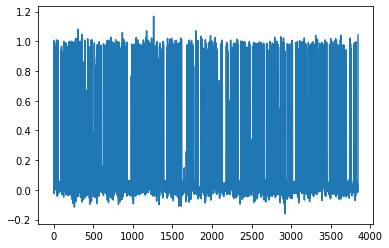

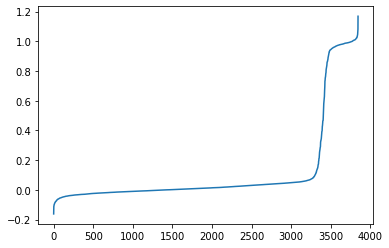


Training set
(3162, 30)
At cuttoff of 0.2  truepositive 339 truenegative 6177 falsepositive 112 falsenegative 4 Accuracy 98.25090470446321 %
At cuttoff of 0.3  truepositive 338 truenegative 6195 falsepositive 94 falsenegative 5 Accuracy 98.50723763570566 %
At cuttoff of 0.4  truepositive 338 truenegative 6209 falsepositive 80 falsenegative 5 Accuracy 98.7183353437877 %
At cuttoff of 0.5  truepositive 331 truenegative 6223 falsepositive 66 falsenegative 12 Accuracy 98.8238841978287 %
At cuttoff of 0.6  truepositive 328 truenegative 6238 falsepositive 51 falsenegative 15 Accuracy 99.00482509047045 %
At cuttoff of 0.7  truepositive 321 truenegative 6248 falsepositive 41 falsenegative 22 Accuracy 99.05006031363088 %
At cuttoff of 0.75  truepositive 314 truenegative 6252 falsepositive 37 falsenegative 29 Accuracy 99.00482509047045 %
At cuttoff of 0.8  truepositive 311 truenegative 6260 falsepositive 29 falsenegative 32 Accuracy 99.08021712907117 %
At cuttoff of 0.9  truepositive 298 truene

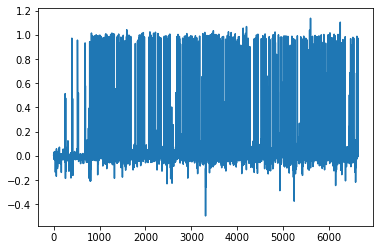

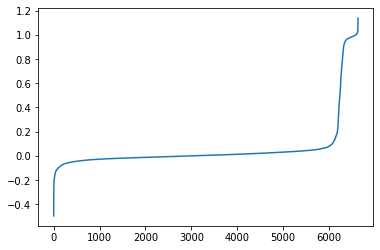

In [13]:
device = torch.device("cpu")

print("test set")
originaldata=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_test_noposeobs_10_21_2021.csv')#.head()
evaluatedataset(gru_model3,originaldata)
print("")
print("Training set")
originaldata2=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_train_noposeobs_10_21_2021.csv')#.head()
print(originaldata2.shape)
evaluatedataset(gru_model3,originaldata2)


Training sets
(3162, 30)
IndexError. headers[h-1]: header9 i+5: 3005 h= 10 i= 3000
classifytest []
labelstest nan


RuntimeError: stack expects a non-empty TensorList

In [41]:
headers=[]

for i in range(30):  
    label=str(i)
    headers.append("header"+label)

choppedheaders=[]
GRUoutputlist=[]
lookback=10 #save only the last 11 timesteps
for i in range(10):  
    label=str(i)
    choppedheaders.append("header"+label)

i=3000
h=10
classifytest=originaldata2[headers[h-10:h]].iloc[i:i+5].to_numpy()
print("classifytest",classifytest)
labelstest=originaldata2[headers[h-1]].iloc[i+5]
print("labelstest",labelstest)




classifytest [[ 0.0398911   0.0241225   0.02682633  0.02702141  0.05447834  0.04242745
   0.0366626   0.03491685  0.05158316  0.03480728]
 [-0.15048075 -0.15733948 -0.1513809  -0.14985899 -0.14771663 -0.14492556
  -0.1499112  -0.14839595 -0.14311818 -0.15049482]
 [ 0.8613799   0.85945236  0.86175761  0.86052262  0.85467723  0.85925587
   0.85847605  0.85677542  0.85490485  0.85631822]
 [ 0.17999327  0.18035205  0.18060403  0.18078037  0.1804806   0.18109771
   0.18172166  0.18206136  0.18267563  0.18508794]
 [ 0.07584476  0.07346775  0.07471259  0.07465951  0.07726353  0.07723307
   0.07597563  0.07648185  0.0754467   0.07683962]]
labelstest 0.0


At cuttoff of 0.2  truepositive 310 truenegative 13501 falsepositive 1986 falsenegative 0 Accuracy 87.42799265683358 %
At cuttoff of 0.3  truepositive 310 truenegative 14144 falsepositive 1343 falsenegative 0 Accuracy 91.4983857694499 %
At cuttoff of 0.4  truepositive 310 truenegative 14530 falsepositive 957 falsenegative 0 Accuracy 93.94188770019623 %
At cuttoff of 0.5  truepositive 310 truenegative 14813 falsepositive 674 falsenegative 0 Accuracy 95.73336709501804 %
At cuttoff of 0.6  truepositive 309 truenegative 14999 falsepositive 488 falsenegative 1 Accuracy 96.90447553332912 %
At cuttoff of 0.7  truepositive 308 truenegative 15132 falsepositive 355 falsenegative 2 Accuracy 97.74007722985377 %
At cuttoff of 0.75  truepositive 305 truenegative 15177 falsepositive 310 falsenegative 5 Accuracy 98.0059504969298 %
At cuttoff of 0.8  truepositive 304 truenegative 15228 falsepositive 259 falsenegative 6 Accuracy 98.32246629106793 %
At cuttoff of 0.9  truepositive 298 truenegative 15320 

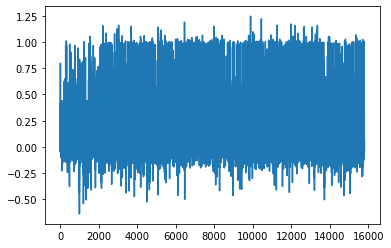

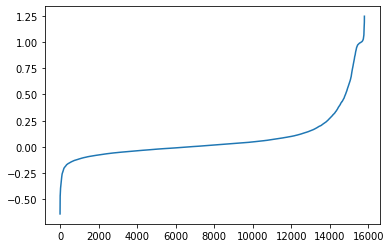

In [143]:
originaldata=pd.read_csv('forcetorquebuttonresults_cylindernobutton_10_19_2021.csv')
evaluatedataset(gru_model3,originaldata)

print("")


In [139]:
 (310+13501)/(310+13501+1986)

0.8742799265683358

In [136]:
row=897

headers=[]
for i in range(30):  
    label=str(i)
    headers.append("header"+label)

choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(10):  
    label=str(i)
    choppedheaders.append("header"+label)

okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[row*6:(row*6)+5].to_numpy()
    #print(classifytest)
    labelstest=originaldata[headers[i:10+i]].iloc[(row*6)+5].to_numpy()
    print(labelstest)
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 0 - 10  : -0.008711494505405426 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 1 - 11  : 0.003979824483394623 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 2 - 12  : -0.01775369793176651 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 3 - 13  : 0.2741720378398895 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 4 - 14  : 0.1268426775932312 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 5 - 15  : 0.24690017104148865 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 6 - 16  : -0.008548252284526825 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 7 - 17  : -0.055137209594249725 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 8 - 18  : 0.06283382326364517 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 9 - 19  : 0.0840025767683982